# 05 · Budget Optimization / What-if

**Goal:** Run fixed and flexible budget optimization scenarios and visualize suggested allocations.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV
from scipy.optimize import minimize

df = pd.read_csv("../data/marketing_data_clean.csv")
channels = ["tv_spend","search_spend","social_spend","display_spend"]
controls = ["price_index","promo","holiday"]

y = df["revenue"].values
Z = df[controls].values
X_raw = df[channels].values

def adstock(x, L=8, alpha=0.6):
    w = alpha ** np.arange(L)
    w = w / w.sum()
    return np.convolve(x, w, mode="full")[:len(x)]

def saturation(x, k=1.0, s=0.6):
    return (x**s) / (x**s + k**s)

X_list = []
for c in channels:
    xs = adstock(df[c].values, L=8, alpha=0.6)
    k = np.quantile(xs, 0.7) + 1e-6
    xs = saturation(xs, k=k, s=0.6)
    X_list.append(xs)
X = np.vstack(X_list).T

pipe = Pipeline([
    ("scale", ColumnTransformer(
        transformers=[
            ("x", StandardScaler(), slice(0, len(channels))),
            ("z", StandardScaler(), slice(len(channels), len(channels)+Z.shape[1])),
        ], remainder="drop"
    )),
    ("ridge", RidgeCV(alphas=np.logspace(-3, 3, 21), cv=5))
])

XZ = np.hstack([X, Z])
pipe.fit(XZ, y)

print("Pipeline trained. Coef (first 4 = media):")
pipe.named_steps["ridge"].coef_[:len(channels)]

Pipeline trained. Coef (first 4 = media):


array([  454.61711131,   -46.3875149 ,   413.09152997, -1635.51862706])

In [3]:
base_spend = df[channels].values
S0 = base_spend.mean(axis=0)  
B0 = S0.sum()                 

def forward(spend_vec):
    X_opt_list = []
    n = len(y)
    ones = np.ones(n)
    for i, c in enumerate(channels):
        xs = adstock(spend_vec[i] * ones, L=8, alpha=0.6)
        k  = np.quantile(xs, 0.7) + 1e-6
        xs = saturation(xs, k=k, s=0.6)
        X_opt_list.append(xs)
    X_opt = np.vstack(X_opt_list).T  # (n, k)
    XZ_opt = np.hstack([X_opt, Z])
    return pipe.predict(XZ_opt).sum()


In [5]:
def optimize_budget(total_budget,
                    lower_pct=0.5, upper_pct=2.0,
                    initial="current"):
    if initial == "equal":
        x0 = np.ones(len(channels)) * (total_budget / len(channels))
    else:
        x0 = S0.copy()

    cons = ({'type':'eq', 'fun': lambda s: s.sum() - total_budget},)

    bnds = [(S0[i]*lower_pct, S0[i]*upper_pct) for i in range(len(channels))]

    res = minimize(lambda s: -forward(s),
                   x0=x0, bounds=bnds, constraints=cons, method="SLSQP")

    out = pd.DataFrame({
        "channel": channels,
        "current": S0,
        "optimized": res.x,
        "delta": res.x - S0,
        "delta_%": (res.x - S0) / S0
    }).round(2)

    out_meta = {
        "budget_current": float(B0),
        "budget_target": float(total_budget),
        "pred_revenue_current": float(forward(S0)),
        "pred_revenue_optimized": float(forward(res.x)),
        "uplift": float(forward(res.x) - forward(S0))
    }
    return out, out_meta

In [7]:
plan_same, meta_same = optimize_budget(B0, lower_pct=0.5, upper_pct=2.0, initial="current")
display(plan_same)
meta_same

plan_up10, meta_up10 = optimize_budget(1.10 * B0, lower_pct=0.5, upper_pct=2.0)
display(plan_up10)
meta_up10

plan_down20, meta_down20 = optimize_budget(0.80 * B0, lower_pct=0.5, upper_pct=2.0)
display(plan_down20)
meta_down20

,channel,current,optimized,delta,delta_%
0,tv_spend,9147.24,9147.24,-0.0,-0.0
1,search_spend,4380.46,4380.46,-0.0,-0.0
2,social_spend,2403.69,2403.69,-0.0,-0.0
3,display_spend,1415.61,1415.61,0.0,0.0


,channel,current,optimized,delta,delta_%
0,tv_spend,9147.24,9580.85,433.61,0.05
1,search_spend,4380.46,4814.08,433.61,0.10
2,social_spend,2403.69,2837.30,433.61,0.18
3,display_spend,1415.61,1849.47,433.86,0.31


,channel,current,optimized,delta,delta_%
0,tv_spend,9147.24,8226.71,-920.53,-0.10
1,search_spend,4380.46,3459.93,-920.53,-0.21
2,social_spend,2403.69,1483.16,-920.53,-0.38
3,display_spend,1415.61,707.80,-707.80,-0.50


{'budget_current': 17347.004567307693,
 'budget_target': 13877.603653846156,
 'pred_revenue_current': 17296948.229599044,
 'pred_revenue_optimized': 17296948.230179682,
 'uplift': 0.0005806386470794678}

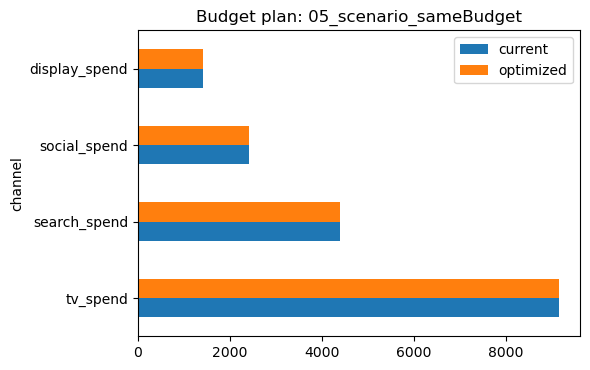

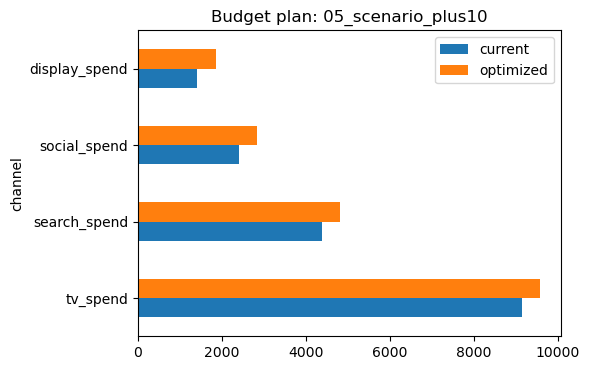

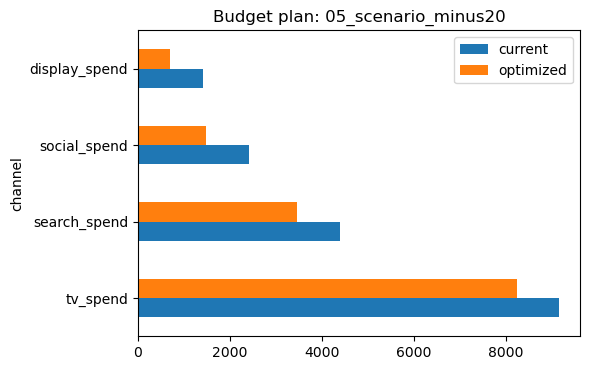

In [9]:
import matplotlib.pyplot as plt

OUT = Path("../reports")
OUT.mkdir(exist_ok=True)

def save_plan(plan_df, meta, name):
    plan_df.to_csv(OUT / f"{name}_budget_plan.csv", index=False)
    with open(OUT / f"{name}_meta.txt", "w") as f:
        for k,v in meta.items():
            f.write(f"{k}: {v}\n")

    ax = plan_df.plot(kind="barh", x="channel", y=["current","optimized"], figsize=(6,3.8), title=f"Budget plan: {name}")
    plt.tight_layout()
    plt.savefig(OUT / f"{name}_budget_bar.png", dpi=150)
    plt.show()

save_plan(plan_same,  meta_same,  "05_scenario_sameBudget")
save_plan(plan_up10,  meta_up10,  "05_scenario_plus10")
save_plan(plan_down20,meta_down20,"05_scenario_minus20")

**Budget Optimization**

* We use the regularized MMM (Ridge + Adstock + Saturation) trained in step 03 to maximize predicted revenue under budget constraints.

* Decision variables are weekly channel budgets; constraints include:

     * total spend equals a target budget (same, +10%, −20% scenarios),

     * per-channel lower/upper bounds relative to the current mix (default: 50%–200%).

* Optimization is solved with SLSQP.

* The notebook outputs per-channel current vs. optimized budgets, predicted revenue uplift, and exports results to ../reports/ as CSV/PNG.